In [1]:
from transformers import GPT2Tokenizer, GPT2Model
import torch
import numpy as np
import matplotlib.pyplot as plt
import re

/opt/homebrew/Caskroom/miniforge/base/envs/DL-systems/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
from src.exploration_utils import gpt_layer_analysis, collect_params, plot_weight_distro, plot_weights_across_layers

In [8]:
%load_ext autoreload

In [9]:
%autoreload 2

In [3]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-xl')
model = GPT2Model.from_pretrained('gpt2-xl')

In [4]:
model.named_parameters

<bound method Module.named_parameters of GPT2Model(
  (wte): Embedding(50257, 1600)
  (wpe): Embedding(1024, 1600)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0): GPT2Block(
      (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): GPT2Block(
      (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (

In [5]:
params = model.state_dict() 

In [6]:
len(params.keys())

676

### GPT2-XL Architecture
Each of the 48 layers of GPT-XL consists of:
<br>
#### Layer Norm 1
'h.0.ln_1.weight' # [1600]
<br>
'h.0.ln_1.bias # [1600]'
<br>

#### Self-Attention
'h.0.attn.bias' # [1, 1, 1024, 1024]
<br>
'h.0.attn.masked_bias' # []
<br>
'h.0.attn.c_attn.weight' # [1600, 4800]
<br>
'h.0.attn.c_attn.bias' # [4800]
<br>
'h.0.attn.c_proj.weight' # [1600, 1600]
<br>
'h.0.attn.c_proj.bias' # [1600]
<br>

#### Layer Norm 2
'h.0.ln_2.weight' # [1600]
<br>
'h.0.ln_2.bias' # [1600]
<br>

#### Feed Forward
'h.0.mlp.c_fc.weight' # [1600, 6400]
<br>
'h.0.mlp.c_fc.bias' # [6400]
<br>
'h.0.mlp.c_proj.weight' [6400, 1600]
<br>
'h.0.mlp.c_proj.bias' # [1600]


In [246]:
print(f"Total Parameters: {sum(p.numel() for p in model.parameters())}")

Total Parameters: 1557611200


In [30]:
bins_labs = ["0 to 1E-06", "1E-06 to 1E-05", "1E-05 to 1E-04", "1E-04 to 1E-03",
             "1E-03 to 1E-02", "1E-02 to 1E-01", "1E-01 to 1", "1 to 10"]

### Overall analysis

In [ ]:
non_embed_param_names = list(params.keys())
non_embed_param_names.remove('wpe.weight')
non_embed_param_names.remove('wte.weight')
all_layers = collect_params(params, non_embed_param_names)

In [237]:
len(non_embed_param_names)

674

In [241]:
all_layers.shape

torch.Size([1525893248])

In [242]:
cnts_all, pcts_all = weight_size_distro(all_layers)

In [243]:
pcts_all

array([1.64967215e-02, 1.82185091e-04, 1.81961484e-03, 1.81910425e-02,
       1.79178803e-01, 7.51039324e-01, 1.65812366e-02, 1.65110731e-02])

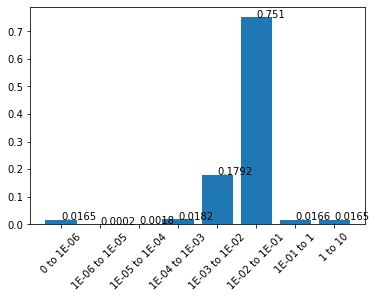

In [244]:
plot_weight_distro(bins_labs, pcts_all)

The plot above shows that 75% of the 1.5 billion non-embedding parameters in gpt-xl have an absolute value between .001 and .01. A further 18% of parameters are between .0001 and .001. The remaining ~7% of weights are equally distributed between being larger than .001 and smaller than .0001

### Layer by layer analysis

In [ ]:
layer_results = np.empty((48,9))
for layer_num in range(48):
    cnts, pcts = gpt_layer_analysis(layer_num, params)
    layer_results[layer_num, 0] = layer_num
    layer_results[layer_num, 1:] = pcts

In [27]:
import pandas as pd
layer_results = pd.DataFrame(layer_results)

In [35]:
colnames = ['layer_num']
colnames.extend(bins_labs)

In [38]:
layer_results.columns = colnames

In [39]:
layer_results.head()

,layer_num,0 to 1E-06,1E-06 to 1E-05,1E-05 to 1E-04,1E-04 to 1E-03,1E-03 to 1E-02,1E-02 to 1E-01,1E-01 to 1,1 to 10
0,0.0,0.016506,0.000251,0.002537,0.025325,0.241251,0.674029,0.023592,0.016509
1,1.0,0.016501,0.000210,0.002147,0.021365,0.209083,0.723515,0.010666,0.016513
2,2.0,0.016498,0.000215,0.002086,0.020905,0.204392,0.727181,0.012212,0.016511
3,3.0,0.016499,0.000200,0.002041,0.020342,0.199281,0.731352,0.013776,0.016509
4,4.0,0.016498,0.000202,0.002008,0.020111,0.197530,0.733310,0.013833,0.016509


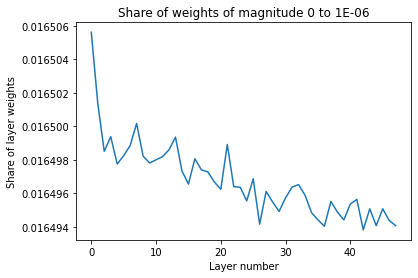

In [43]:
plot_weights_across_layers('0 to 1E-06', layer_results)

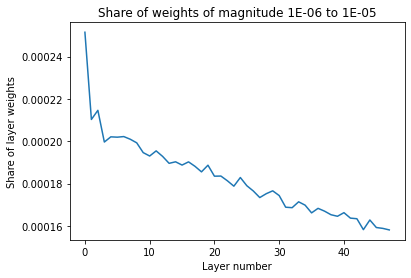

In [46]:
plot_weights_across_layers('1E-06 to 1E-05', layer_results)

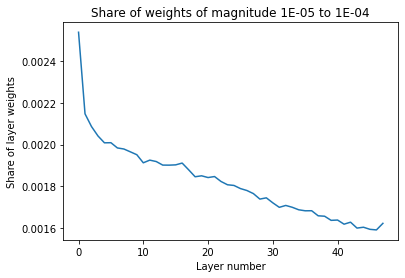

In [47]:
plot_weights_across_layers('1E-05 to 1E-04', layer_results)

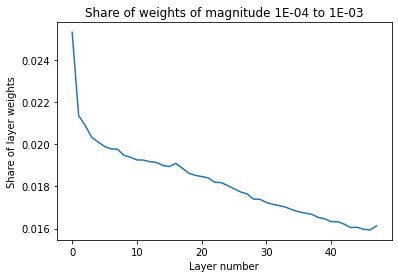

In [48]:
plot_weights_across_layers('1E-04 to 1E-03', layer_results)

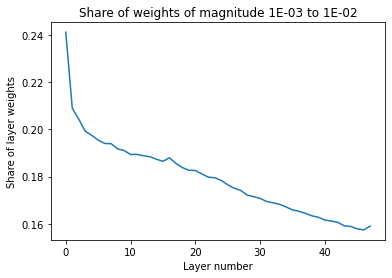

In [49]:
plot_weights_across_layers('1E-03 to 1E-02', layer_results)

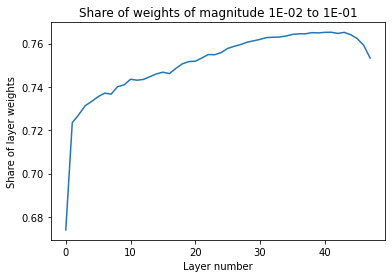

In [50]:
plot_weights_across_layers('1E-02 to 1E-01', layer_results)

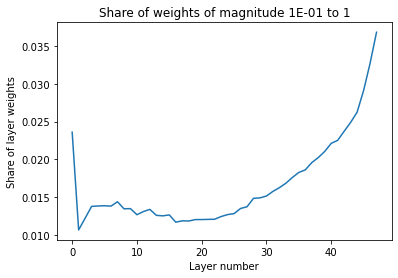

In [51]:
plot_weights_across_layers('1E-01 to 1', layer_results)

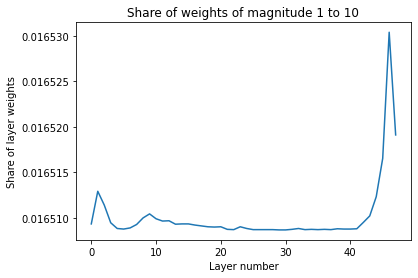

In [52]:
plot_weights_across_layers('1 to 10', layer_results)